In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys 
sys.path.append('../../src')

In [4]:
import scanpy as sc

In [5]:
import sys
sys.path.append('/Users/koush/Projects/SpaceOracle/src/')
sys.path.append('/Users/koush/Projects/Banksy_py')
import celloracle as co

In [6]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/mouse_brain_wt_slideseq.h5ad')
adata

AnnData object with n_obs × n_vars = 23409 × 3311
    obs: 'cell_type', 'cell_type_int', 'seurat_clusters', 'umap_1', 'umap_2', 'author_cell_type'
    uns: 'cell_thresholds', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_umap', 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

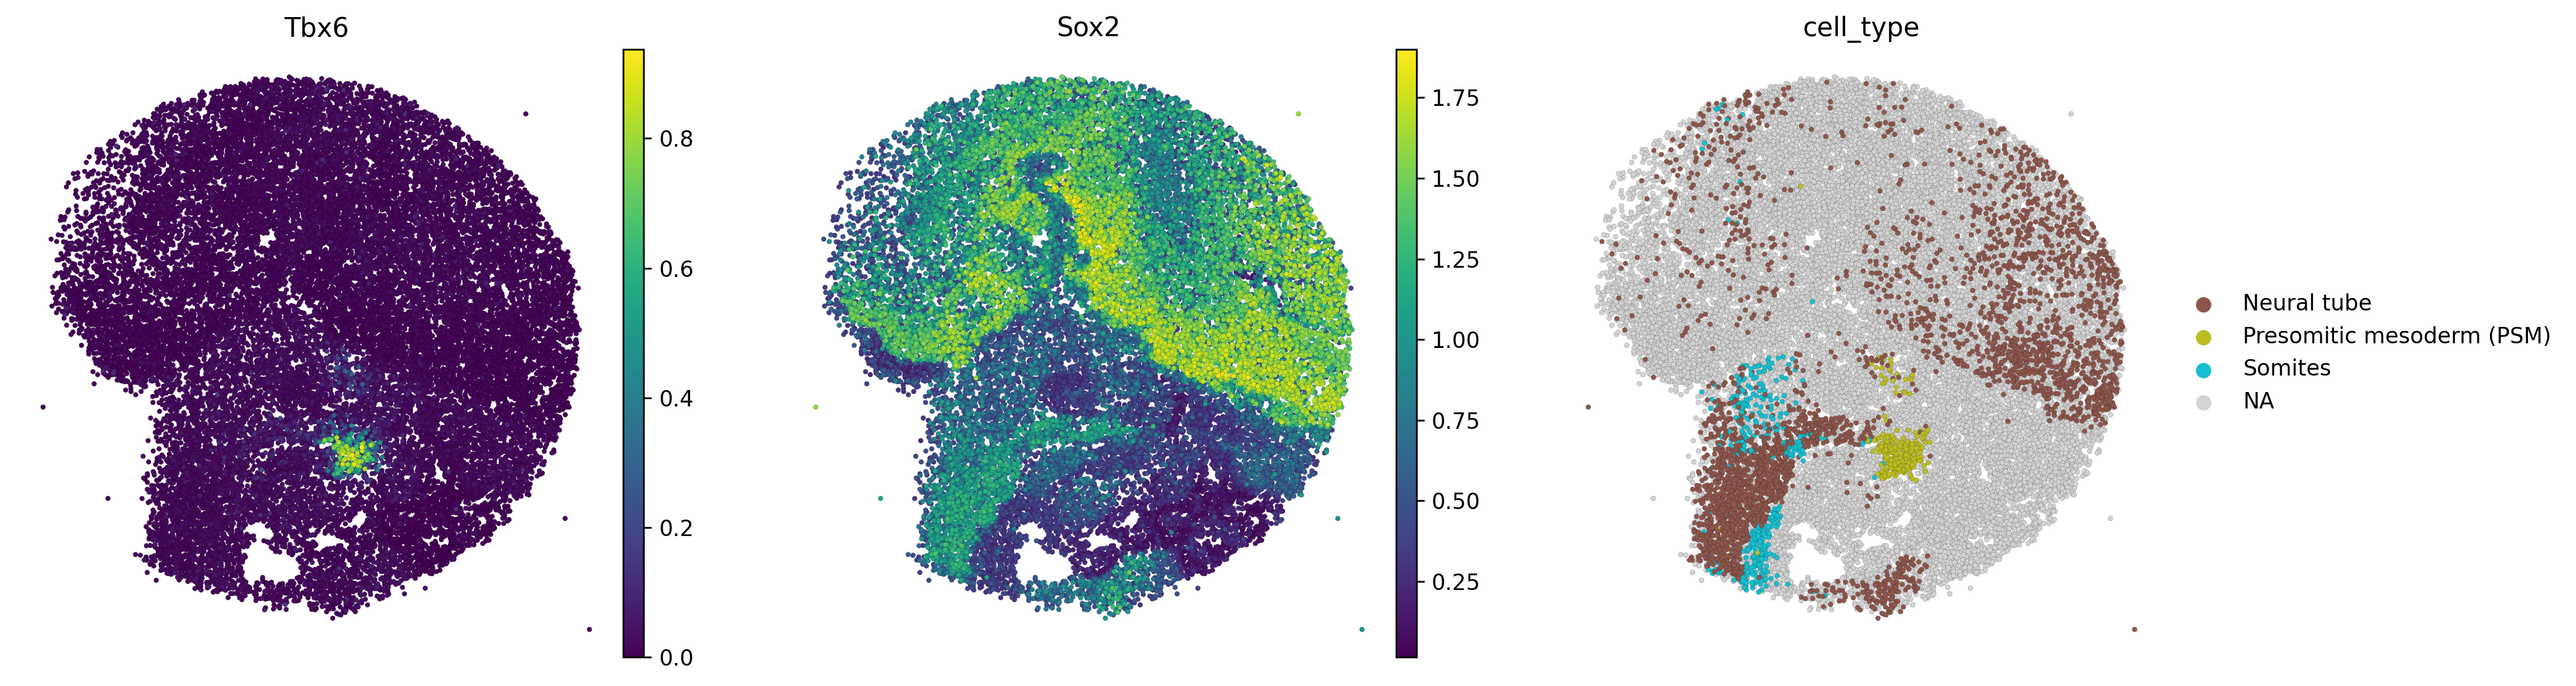

In [7]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['figure.dpi'] = 120

sc.pl.embedding(
    adata, basis='spatial', 
    frameon=False, color=['Tbx6', 'Sox2', 'cell_type'],
    groups=['Neural tube', 'Somites', 'Presomitic mesoderm (PSM)'],
    palette='tab10',
    s=20, linewidth=0.05, edgecolor='black', layer='imputed_count',
    ncols=3
)
plt.show()

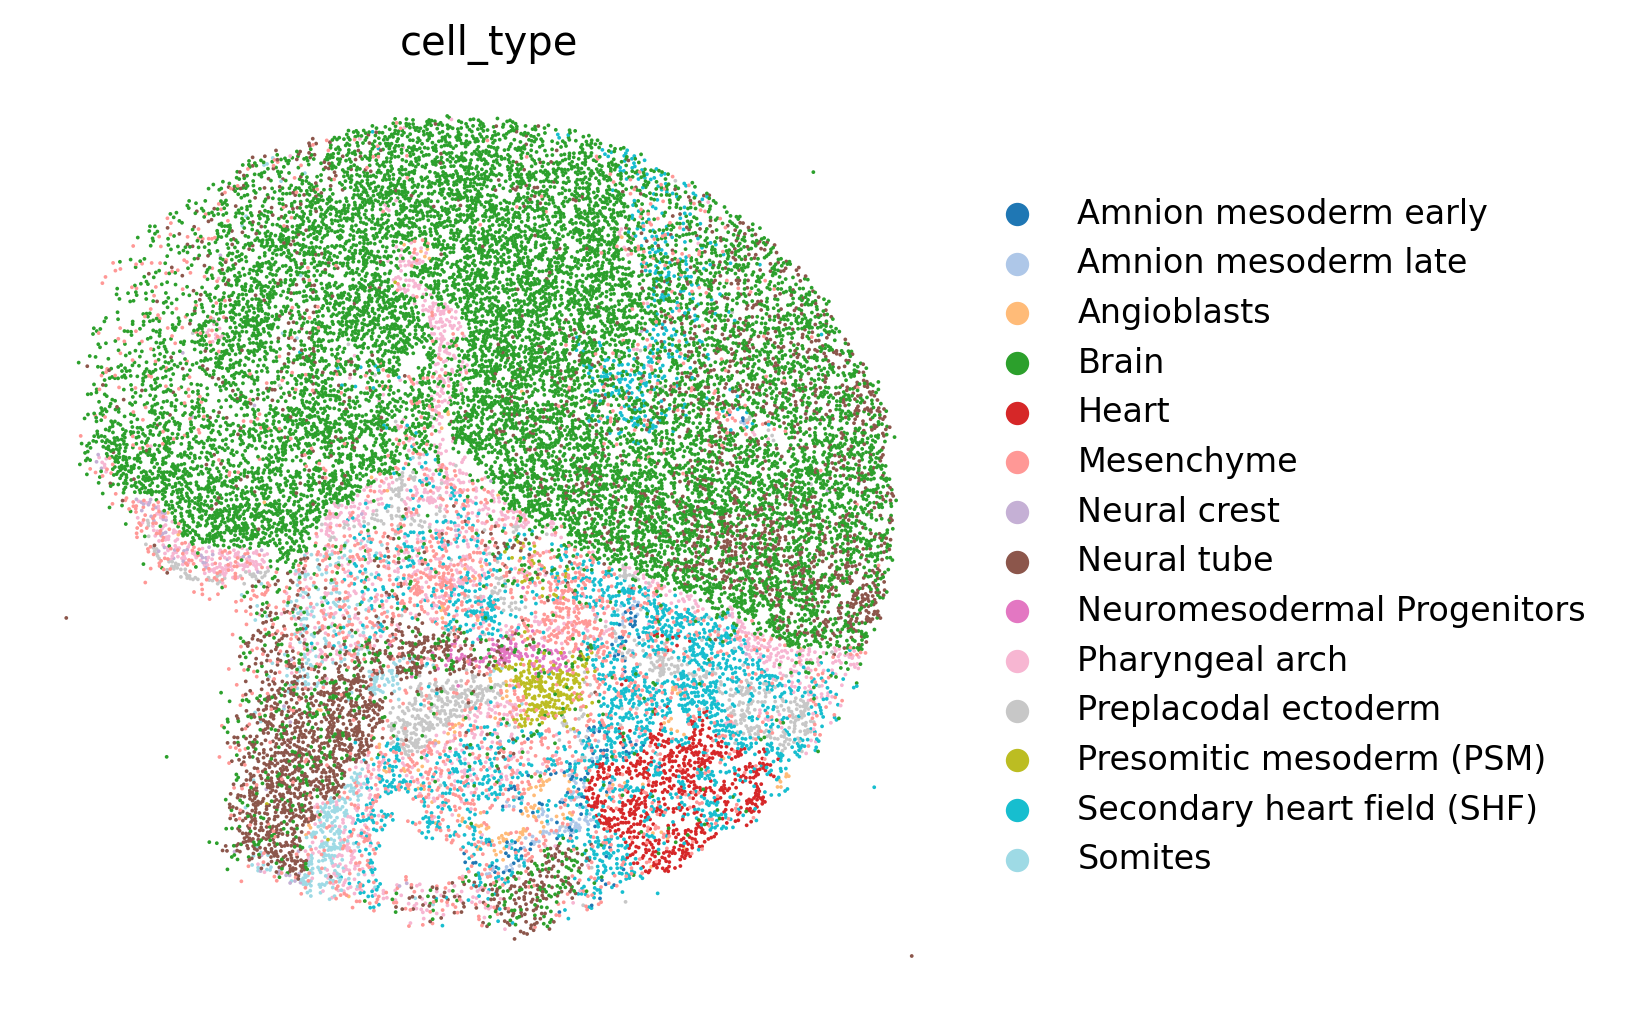

In [44]:
sc.pl.embedding(
    adata, basis='spatial', 
    frameon=False, color=['cell_type'],
    palette='tab20'
)

In [8]:
from spaceoracle.plotting.cartography import xy_from_adata, plot_cells

xy = xy_from_adata(adata)

In [9]:
adata.to_df(layer='imputed_count').values.max()

5.029922075676621

In [10]:
%matplotlib inline

In [11]:
from spaceoracle.tools.network import RegulatoryFactory
co_grn = RegulatoryFactory(
    colinks_path='/Users/koush/Desktop/training_data/mouse_brain_wt_slideseq_colinks.pkl',
    annot='cell_type_int'
)

In [21]:
from spaceoracle.models.parallel_estimators import SpatialCellularProgramsEstimator

estimator = SpatialCellularProgramsEstimator(
    adata, 
    target_gene='Sox2', 
    cluster_annot='cell_type_int',
    radius=200, 
    contact_distance=30,
    grn=co_grn,
)

In [67]:
# estimator.plot_modulators()

In [38]:
estimator.adata.obs[['cell_type', 'cell_type_int']].value_counts()

cell_type                     cell_type_int
Brain                         3                12254
Neural tube                   7                 2957
Secondary heart field (SHF)   12                2192
Mesenchyme                    5                 2114
Pharyngeal arch               9                 1368
Preplacodal ectoderm          10                 708
Heart                         4                  612
Somites                       13                 401
Presomitic mesoderm (PSM)     11                 237
Angioblasts                   2                  159
Amnion mesoderm early         0                  117
Neuromesodermal Progenitors   8                  113
Amnion mesoderm late          1                  102
Neural crest                  6                   75
Name: count, dtype: int64

In [30]:
estimator.fit(num_epochs=1, learning_rate=5e-3, 
    score_threshold=0.2, l1_reg=1e-9, 
    estimator='lasso', skip_clusters=[0, 1, 2, 3, 4, 5, 6])

Fitting Sox2 with 1097 modulators
	41 Transcription Factors
	987 Ligand-Receptor Pairs
	69 TranscriptionFactor-Ligand Pairs
7: 0.6776 | 0.8757
8: x.xxxx | 0.8849
9: 0.7108 | 0.8527
10: x.xxxx | 0.7471
11: 0.2291 | 0.8259
12: 0.8339 | 0.9287
13: 0.4196 | 0.8980


In [45]:
betadata = estimator.betadata

0 (117, 1098)
1 (102, 1098)
2 (159, 1098)
3 (12254, 1098)
4 (612, 1098)
5 (2114, 1098)
6 (75, 1098)
7 (2957, 1098)
8 (113, 1098)
9 (1368, 1098)
10 (708, 1098)
11 (237, 1098)
12 (2192, 1098)
13 (401, 1098)


In [107]:
adata.obs[['cell_type_int', 'cell_type']].drop_duplicates()

cell_type_int                     cell_type
201112_04_CATCATTAATGGGA             0         Amnion mesoderm early
201112_04_TCTTGACCAAGGGC             7                   Neural tube
201112_04_CCCGMSTTCCAAGG             4                         Heart
201112_04_CAGAGAHAAAGCGA             2                   Angioblasts
201112_04_ACGACTTGAGTATT             3                         Brain
201112_04_GCCGTCCAGCCGCT            12   Secondary heart field (SHF)
201112_04_CCATCTATCAGCCA            13                       Somites
201112_04_GCCCGCTTAGCCCG            10          Preplacodal ectoderm
201112_04_CGTAGGGACATAAC             8  Neuromesodermal Progenitors 
201112_04_CGACCTTCAACAGC             9               Pharyngeal arch
201112_04_CAAATGGCCGACTT            11     Presomitic mesoderm (PSM)
201112_04_ACAMAACGTGACGA             6                  Neural crest
201112_04_ACAAGACGCTCGGC             5                    Mesenchyme
201112_04_TACCGCAACTTCTC             1          Amnion mesoderm late

In [109]:
betadata.mean().sort_values(ascending=False, key=abs).head(25)

beta_Heyl          0.171796
beta_Foxs1         0.168649
beta_Hand1         0.165009
beta_Esrrg         0.120079
beta_Ets1          0.119954
beta_Mlxipl        0.115799
beta_Thrb          0.115719
beta_Egr1          0.106240
beta_Irf2          0.086805
beta_Pax5         -0.081387
beta_Tfap2c       -0.077084
beta_Tcf15         0.075715
beta_Foxe1        -0.074492
beta_Foxp3        -0.070729
beta_Arntl2        0.064093
beta_Stat1         0.063501
beta_Mdk$Itgb1     0.057226
beta_Tfap2a        0.057155
beta_Hand2         0.056586
beta_Zic3         -0.056478
beta_Igf2$Igf2r    0.052387
beta_Myog         -0.050888
beta_Ehf           0.049816
beta_Nr1h3         0.048685
beta_Ppargc1a      0.048177
dtype: float32

In [19]:
pd.DataFrame({f'cluster_{i}': estimator.models[i].anchors.cpu().numpy()[1:] 
    for i in range(len(estimator.models))}, index=estimator.modulators)['cluster_3'].loc[
        estimator.regulators].sort_values(
        ascending=False, key=abs).head(20)

Pax8     -3.447659
Irf1      2.608952
Foxe1    -2.192187
Six5      2.052267
Arntl2    1.552688
Stat1     1.540473
Zbtb7b    1.364665
Elf1      1.285048
Wt1      -1.137516
Sp8       0.998582
Foxa2     0.790064
Egr1     -0.738223
Klf14     0.719406
Rarg     -0.710974
Nfya      0.657669
Foxd3    -0.651645
Sp6       0.583733
Hes7     -0.556903
Tfap2a    0.533543
Id4       0.517596
Name: cluster_3, dtype: float32

In [110]:
from spaceoracle.plotting.cartography import xy_from_adata

xy = xy_from_adata(estimator.adata)

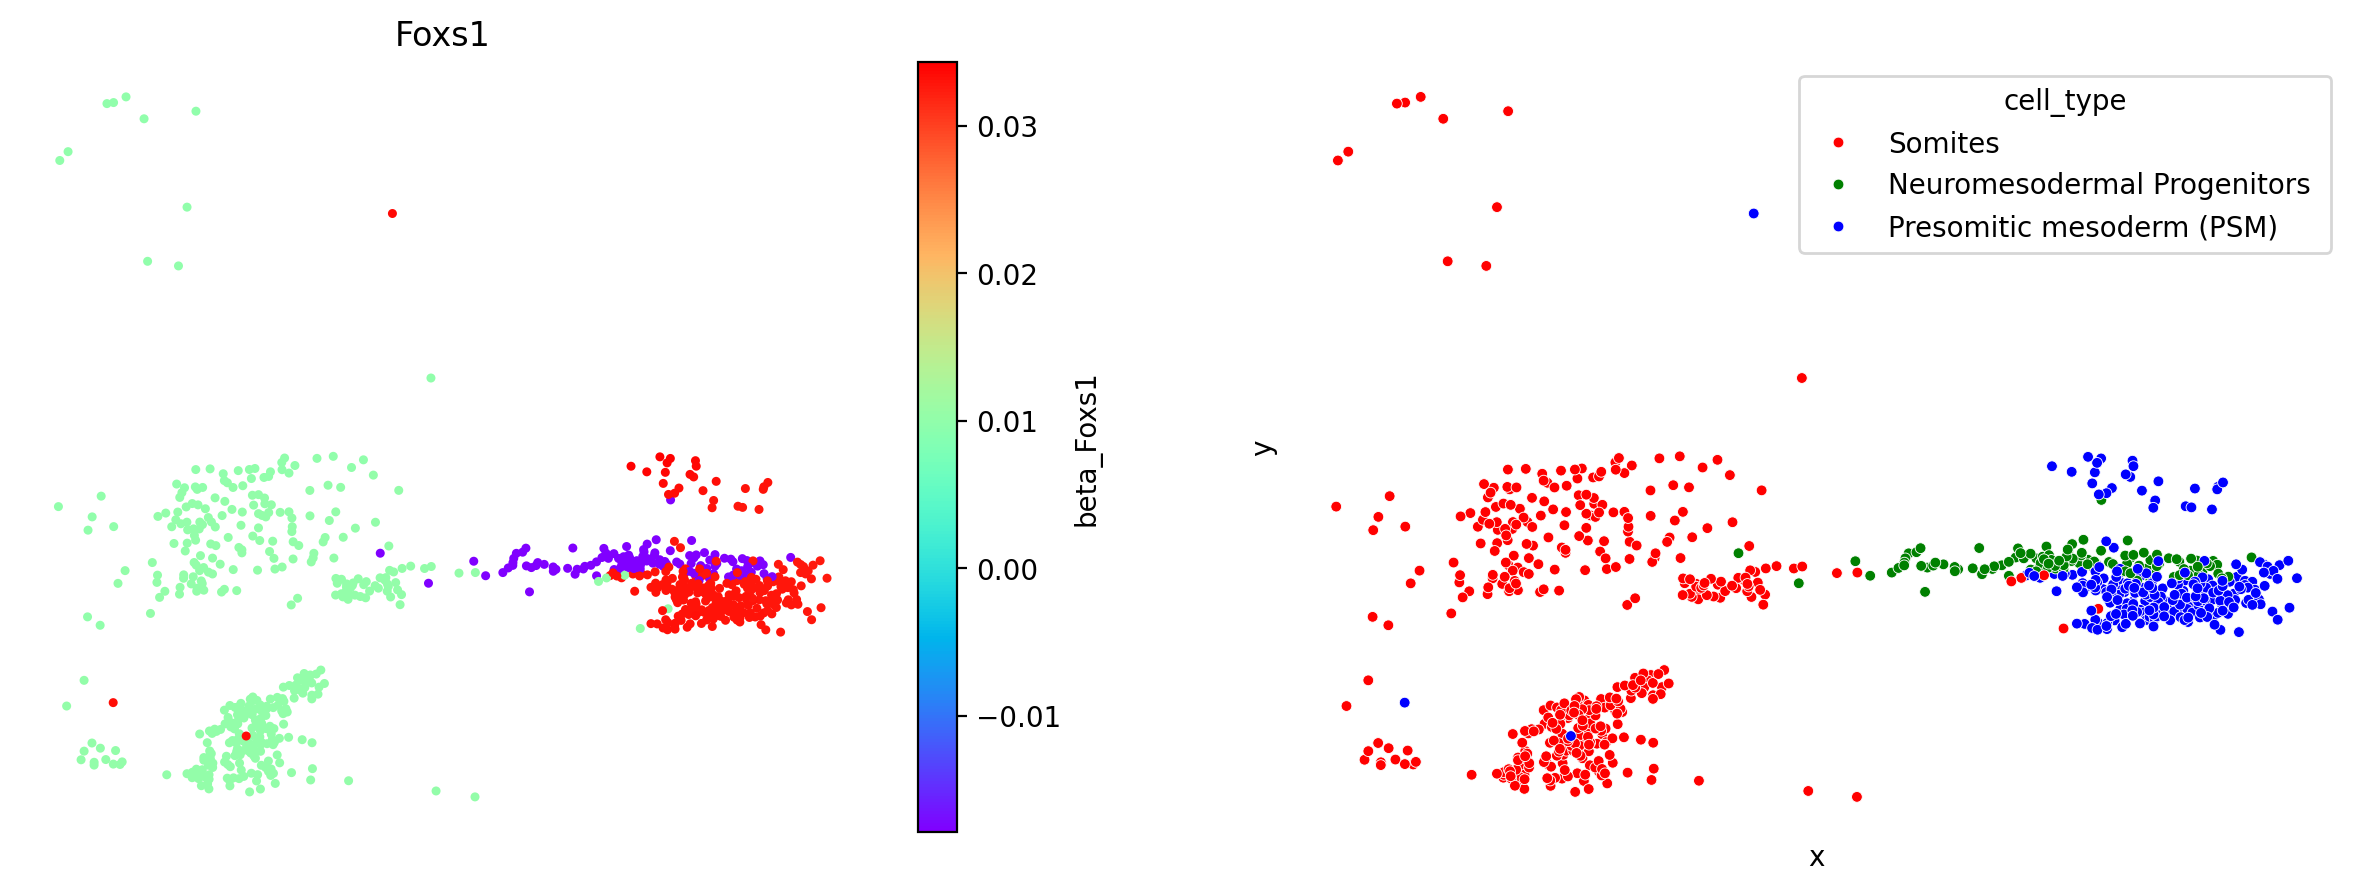

In [122]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
cmap = 'rainbow'
selected = 'Foxs1'
data = betadata.join(estimator.adata.obs[['cell_type_int', 'cell_type']]).join(xy).query(
    'cell_type_int.isin([8, 13, 11])')[
    ['x', 'y', f'beta_{selected}', 'cell_type']].join(estimator.train_df[[f'{selected}']])

data.cell_type = data.cell_type.astype(str)

scatter1 = ax[0].scatter(
    data['x'],
    data['y'], 
    c=data[f'beta_{selected}'],
    s=5,
    cmap=cmap
)
f.colorbar(scatter1, ax=ax[0], label=f'beta_{selected}')

scatter2 = sns.scatterplot(
    data=data,
    x='x',
    y='y',
    hue='cell_type',
    s=15,
    legend=True,
    palette=['red', 'green', 'blue'],
    ax=ax[1],
)

for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    for spine in ['top', 'right', 'left', 'bottom']:
        a.spines[spine].set_visible(False)
        
ax[0].set_title(selected)
plt.show()

In [28]:
adata.obs[['cell_type_int', 'cell_type']].drop_duplicates()

cell_type_int                     cell_type
201112_04_CATCATTAATGGGA             0         Amnion mesoderm early
201112_04_TCTTGACCAAGGGC             7                   Neural tube
201112_04_CCCGMSTTCCAAGG             4                         Heart
201112_04_CAGAGAHAAAGCGA             2                   Angioblasts
201112_04_ACGACTTGAGTATT             3                         Brain
201112_04_GCCGTCCAGCCGCT            12   Secondary heart field (SHF)
201112_04_CCATCTATCAGCCA            13                       Somites
201112_04_GCCCGCTTAGCCCG            10          Preplacodal ectoderm
201112_04_CGTAGGGACATAAC             8  Neuromesodermal Progenitors 
201112_04_CGACCTTCAACAGC             9               Pharyngeal arch
201112_04_CAAATGGCCGACTT            11     Presomitic mesoderm (PSM)
201112_04_ACAMAACGTGACGA             6                  Neural crest
201112_04_ACAAGACGCTCGGC             5                    Mesenchyme
201112_04_TACCGCAACTTCTC             1          Amnion mesoderm late

In [103]:
betadata[[i for i in betadata.columns if 'Shh' in i]].mean()

beta_Shh$Ptch1   -1.841244e-04
beta_Shh$Smo     -5.401439e-05
beta_Shh$Ptch2    1.224366e-05
beta_Shh#Zic1     8.865427e-07
dtype: float32